### Load Model Samples

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn
from trustworthai.run.model_load.load_punet import load_p_unet
from trustworthai.run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

print("banana")

strawberry
banana


In [2]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [3]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [4]:
def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    # folder arguments
    parser.add_argument('--ckpt_dir', default='s2208943/results/revamped_models/', type=str)
    parser.add_argument('--model_name', default=None, type=str)
    
    # data generation arguments
    parser.add_argument('--dataset', default='ed', type=str)
    parser.add_argument('--seed', default=3407, type=int)
    parser.add_argument('--test_split', default=0.15, type=float)
    parser.add_argument('--val_split', default=0.15, type=float)
    parser.add_argument('--empty_slice_retention', default=0.1, type=float)
    
    # model specific parameters SSN
    parser.add_argument('--ssn_rank', default=15, type=int)
    parser.add_argument('--ssn_epsilon', default=1e-5, type=float)
    parser.add_argument('--ssn_mc_samples', default=10, type=int)
    parser.add_argument('--ssn_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--ssn_pre_head_layers', default=16, type=int)
    
    # evidential loss parameters
    parser.add_argument('--kl_factor', default=0.1, type=float)
    parser.add_argument('--kl_anneal_count', default=452*4, type=int)
    
     # model specific parameters Punet
    parser.add_argument('--kl_beta', default=10.0, type=float)
    parser.add_argument('--use_prior_for_dice', default=False, type=bool)
    parser.add_argument('--punet_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--latent_dim', default=12, type=int)
    
    # general arguments for the loss function
    parser.add_argument('--dice_factor', default=5, type=float)
    parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    
    # general arguments for the loss function
    parser.add_argument('--loss_name', default='dice+xent', type=str)
    # parser.add_argument('--dice_factor', default=5, type=float)
    # parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--xent_weight', default='none', type=str)
    #parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    parser.add_argument('--tversky_beta', default=0.7, type=float)
    parser.add_argument('--reduction', default='mean_sum', type=str)
    
    # training paradigm arguments
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--dropout_p', default=0.0, type=float)
    parser.add_argument('--max_epochs', default=100, type=int)
    parser.add_argument('--early_stop_patience', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--cross_validate', default=False, type=bool)
    parser.add_argument('--cv_split', default=0, type=int)
    parser.add_argument('--cv_test_fold_smooth', default=1, type=int)
    parser.add_argument('--weight_decay', default=0.0001, type=float)
    parser.add_argument('--overwrite', default=False, type=bool)
    
    return parser

In [5]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [6]:
def entropy_map_from_mean(mean, do_normalize=True):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map

In [7]:
def generate_means_and_samples_SSN_Ens(splits=6, dataset_stride=2, temp=1, num_samples=10):
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    model_outs = defaultdict(lambda : defaultdict(lambda : {'means':[], 'samples':[]}))

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.15,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = model_base_name + f"split{split}_ens{ens}/"
            model_path = models_folder + model_name

            # with open(model_path + "best_ckpt.txt") as f:
            #     lines = f.readlines()
            #     args_lines = [l[:-1].split(": ") for l in lines[1:]]
            #     args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            #     args_line = " ".join(args_lines)
            #     parser = construct_parser()
            #     args = parser.parse_args(shlex.split(args_line))

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples // 10, temperature=temp)

                        model_outs[split][i]['means'].append(mean.cpu())
                        model_outs[split][i]['samples'].append(sample.cpu())

                        # means.append(mean.cpu())
                        # samples.append(sample.cpu())

            #model_outs[split][ens] = {'means':means, 'samples':samples}

    for split in model_outs.keys():
        for idx in tqdm(model_outs[split].keys(), position=0, leave=True):
            model_outs[split][idx]['means'] = torch.stack(model_outs[split][idx]['means'], dim=0).mean(dim=0)
            model_outs[split][idx]['samples'] = torch.cat(model_outs[split][idx]['samples'], dim=0)

    means = [model_outs[split][idx]['means'] for split in model_outs.keys() for idx in model_outs[split].keys()]
    samples = [model_outs[split][idx]['samples'] for split in model_outs.keys() for idx in model_outs[split].keys()]

    return means, samples, ConcatDataset(test_datasets)

In [8]:
def generate_means_and_samples_SSN_Ens_Mean(splits=6, dataset_stride=2, temp=1, num_samples=10, components=10):
    # load data
    print("loading")
    clin_retriever = ClinScoreDataRetriever()
    print("loaded")
    
    test_datasets = []

    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    model_raw.return_cpu_dist = True

    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    means = []
    samples = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        # print("size: ", len(test_ds_clin))

        dataskip = dataset_stride

        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0].swapaxes(0,1).cuda()
                distribution_means = []
                distribution_cov_diags = []
                distribution_cov_factors = []
                distribution_event_shapes = []

                for ens in range(components):
                    # print(ens)
                    model_name = model_base_name + f"split{split}_ens{ens}/"
                    model_path = models_folder + model_name
                    model = load_best_checkpoint(model_raw, loss, model_path)
                    model.eval()

                    with torch.no_grad():
                        mean, cov_diag, cov_factor, event_shape = model(x)
                    distribution_means.append(mean.cpu())
                    distribution_cov_diags.append(cov_diag.cpu())
                    distribution_cov_factors.append(cov_factor.cpu())
                    distribution_event_shapes.append(event_shape)

                # print(distribution_means[0].shape)

                distribution_means = torch.stack(distribution_means, dim=0).mean(dim=0)
                distribution_cov_diags = torch.stack(distribution_cov_diags, dim=0).mean(dim=0)
                distribution_cov_factors = torch.stack(distribution_cov_factors, dim=0).mean(dim=0)

                # print(distribution_means.shape)

                dist = LowRankMultivariateNormalCustom(distribution_means, distribution_cov_factors, distribution_cov_diags)
                dist = ReshapedDistribution(dist, distribution_event_shapes[0])

                means.append((dist.mean / temp).cpu())
                samples.append((model_raw._samples_from_dist(dist, num_samples=num_samples)/temp).cpu())

    return means, samples, ConcatDataset(test_datasets)

In [9]:
def generate_means_and_samples_SSN(splits=6, dataset_stride=2, temp=1, num_samples=10, independent=False):
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    rank = 15
    if independent:
        rank = 1
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":rank,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    if independent:
        model_base_name = "ssn_ind_32_cross_validate_"
    else:
        model_base_name = "ssn_cross_validate_32_"
    ensemble_element = 0

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        if independent:
            model_name = model_base_name + f"split{split}/"
        else:
            model_name = model_base_name + f"split{split}_ens{ensemble_element}/"
        model_path = models_folder + model_name

        model = load_best_checkpoint(model_raw, loss, model_path)
        model.eval()

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples, temperature=temp)
                    means.append(mean.cpu())
                    samples.append(sample.cpu())

    return means, samples, ConcatDataset(test_datasets)

In [10]:
def generate_means_and_samples_Ensemble(splits=6, dataset_stride=2, temp=1, num_samples=10):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_outs = defaultdict(lambda : defaultdict(lambda : {'samples':[]}))

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = f"deterministic_ens{ens}_dice+xent_split{split}/"
            model_path = models_folder + model_name

            with open(model_path + "best_ckpt.txt") as f:
                lines = f.readlines()
                args_lines = [l[:-1].split(": ") for l in lines[1:]]
                args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
                args_line = " ".join(args_lines)
                parser = construct_parser()
                args = parser.parse_args(shlex.split(args_line))
                
            model_raw, loss = load_deterministic(args)

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()



            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        sample = model(x.swapaxes(0,1).cuda()).cpu()
                        sample = sample / temp
                        model_outs[split][i]['samples'].append(sample.cpu())

    for split in model_outs.keys():
        for idx in tqdm(model_outs[split].keys(), position=0, leave=True):
            model_outs[split][idx]['samples'] = torch.stack(model_outs[split][idx]['samples'], dim=0)
            model_outs[split][idx]['means'] = model_outs[split][idx]['samples'].mean(dim=0)

    means = [model_outs[split][idx]['means'] for split in model_outs.keys() for idx in model_outs[split].keys()]
    samples = [model_outs[split][idx]['samples'] for split in model_outs.keys() for idx in model_outs[split].keys()]

    return means, samples, ConcatDataset(test_datasets)

In [11]:
def generate_means_and_samples_MC_Dropout(splits=6, dataset_stride=2, temp=1, num_samples=10):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))
        
        model_name = f"mcdropout_dice+xent_split{split}/"
        model_path = models_folder + model_name
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)
        print(args.dropout_p)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    model.eval()
                    mean = model(x.swapaxes(0,1).cuda()).cpu()
                    means.append(mean / temp)
                    ind_samples = []
                    model.train()
                    for j in range(num_samples):
                        sample = model(x.swapaxes(0,1).cuda()).cpu()
                        sample = sample / temp
                        ind_samples.append(sample)
                    samples.append(torch.stack(ind_samples, dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [12]:
def generate_means_and_samples_PUNet(splits=6, dataset_stride=2, temp=1, num_samples=10, prior=True, on_samples=False):
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "punet_lt_"
    if prior:
        typename = "prior"
    else:
        typename = "posterior"
        
    if on_samples:
        samplesname = "on_samples_"
    else:
        samplesname = ""
        
    ensemble_element = 0

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))

        model_name = f"{model_base_name}{typename}_dice_{samplesname}split{split}/"
        model_path = models_folder + model_name
        
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))
        
        model_raw, loss = load_p_unet(args)
        model_raw = model_raw.cuda()

        model = load_best_checkpoint(model_raw, loss, model_path, punet=True)
        model.eval()

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                y = data[1]
                with torch.no_grad():
                    model_raw(x.swapaxes(0,1).cuda(), y.cuda(), training=False)
                    mean = model_raw.sample(use_prior_mean=True).cpu() / temp
                    means.append(mean)
                    
                    ind_samples = []
                    for j in range(num_samples):
                        ind_samples.append(model_raw.sample(testing=False).cpu() / temp)
                    
                    samples.append(torch.stack(ind_samples, dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [13]:
import torch.distributions as td

def generate_means_and_samples_CategoricalSoftmax(splits=6, dataset_stride=2, temp=1, num_samples=10):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))
        
        model_name = f"deterministic_ens0_dice+xent_split{split}/"
        model_path = models_folder + model_name
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)
        print(args.dropout_p)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    model.eval()
                    mean = model(x.swapaxes(0,1).cuda()).cpu() / temp
                    means.append(mean)
                    dist = td.Categorical(probs = torch.softmax(mean, dim=1).moveaxis(1,-1))
                    ind_samples = []
                    samples.append(dist.sample((num_samples,)))
                    
    samples2 = []
    for s in tqdm(samples, position=0, leave=True):
        new_shape = list(s.unsqueeze(2).shape)
        new_shape[2] = 2
        new_s = torch.zeros(new_shape)
        new_s[:,:,0] = 1 - s
        new_s[:,:,1] = s
        samples2.append(new_s)
    samples = samples2

    return means, samples, ConcatDataset(test_datasets)

In [14]:
import torch.distributions as td
from trustworthai.utils.losses_and_metrics.evidential_bayes_risks import *

def generate_means_and_samples_Evidential(splits=6, dataset_stride=2, temp=1, num_samples=10):
    print("strawberry")
    # load data
    clin_retriever = ClinScoreDataRetriever()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))

        model_name = f"evidential_dice+xent_kl01_split{split}/"
        model_path = models_folder + model_name
        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)
        print(args.dropout_p)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        with open(model_path + "best_ckpt.txt") as f:
            lines = f.readlines()
            args_lines = [l[:-1].split(": ") for l in lines[1:]]
            args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            args_line = " ".join(args_lines)
            parser = construct_parser()
            args = parser.parse_args(shlex.split(args_line))

        model_raw, loss = load_deterministic(args)

        # load the model
        model = load_best_checkpoint(model_raw, loss, model_path)

        dataskip = dataset_stride
        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0]
                with torch.no_grad():
                    model.eval()
                    logits = model(x.swapaxes(0,1).cuda()).cpu()
                    evidence = softplus_evidence(logits)
                    alpha = get_alpha(evidence)
                    # print(alpha.shape)
                    S = get_S(alpha)
                    K = alpha.shape[1]
                    mean_p_hat = get_mean_p_hat(alpha, S)
                    means.append(mean_p_hat)
                    dist = td.Dirichlet(alpha.moveaxis(1,-1))
                    ind_samples = []
                    samples.append(dist.sample((num_samples,)).moveaxis(-1, 2))

    return means, samples, ConcatDataset(test_datasets)

In [15]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [16]:
#samples[0].shape

In [17]:
save_folder = "test_categorical/results/"
results_file = save_folder + "text_results.txt"

try:
    os.mkdir(save_folder)
    os.mkdir(save_folder + "/images")
except:
    pass

with open(results_file, "w") as f:
    print_and_write(results_file, "begin results")

NameError: name 'print_and_write' is not defined

In [18]:
stride = 2

In [21]:
means, samples, test_datasets = generate_means_and_samples_SSN(splits=6, dataset_stride=stride, temp=1, num_samples=10)

size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.10it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.25it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.29it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.25it/s]


size:  42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.19it/s]


size:  40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.88it/s]


In [20]:
len(means), len(samples)

(21, 21)

In [69]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
#ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [25]:
samples[0].shape

torch.Size([10, 40, 2, 224, 160])

In [26]:
xs3d_test = []
ys3d_test = []

for i, data in enumerate(test_datasets):
    if i % stride == 0:
        ys3d_test.append(data[1].squeeze())
        xs3d_test.append(data[0])

In [ ]:
stride = 2

def plot_example(save_dir, test_datasets, means, ent_maps, scan_index, slice_index=25):
    imsave(save_dir,
           f"flair_{scan_index}_{slice_index}",
           test_datasets[scan_index * stride][0][0][slice_index],
           cmap='gray',
           title="", small=True, is_img=True, vmin=None, vmax=None, show=False, origin='lower')
    
    imsave(save_dir,
           f"GT_{scan_index}_{slice_index}",
           test_datasets[scan_index * stride][1][0][slice_index],
           cmap='gray',
           title="", small=True, is_img=True, vmin=None, vmax=None, show=False, origin='lower')
    
    imsave(save_dir,
           f"mean_{scan_index}_{slice_index}",
           means[scan_index][slice_index].argmax(dim=0),
           cmap='gray',
           title="", small=True, is_img=True, vmin=None, vmax=None, show=False, origin='lower')
    
    imsave(save_dir,
           f"umap_{scan_index}_{slice_index}",
           ent_maps[scan_index][slice_index],
           cmap='magma',
           title="", small=True, is_img=True, vmin=0, vmax=0.7, show=False, origin='lower')

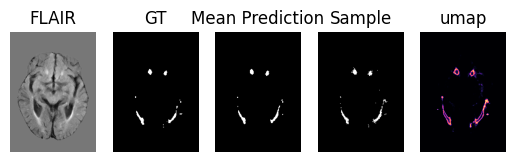

In [45]:
plot_example(87, 15)

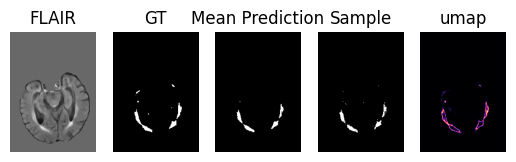

In [46]:
plot_example(51, 15)

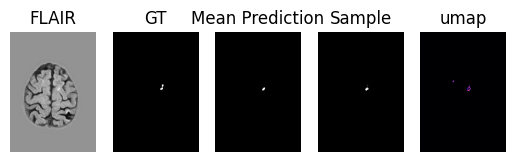

In [47]:
plot_example(23, 35)

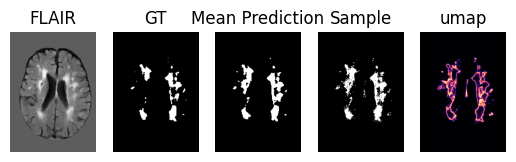

In [48]:
plot_example(103, 35)

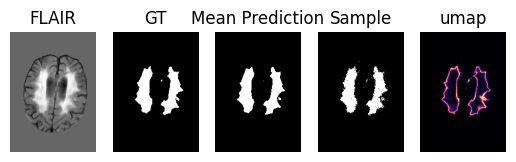

In [49]:
plot_example(52, 35)

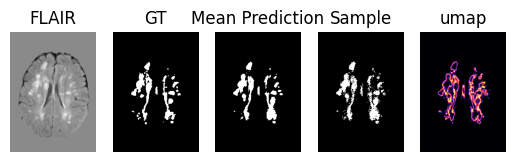

In [50]:
plot_example(1)

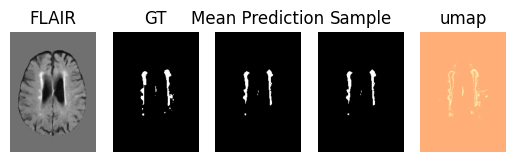

In [32]:
plot_example(0)

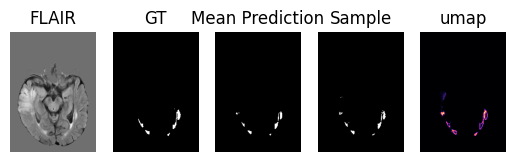

In [52]:
plot_example(104)

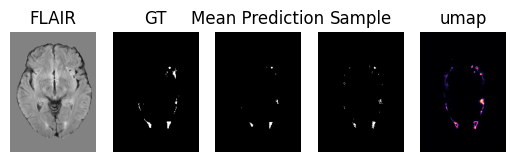

In [53]:
plot_example(57)

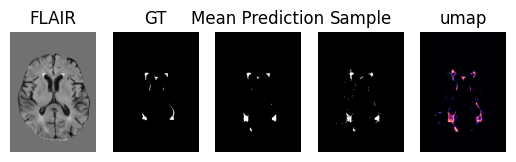

In [54]:
plot_example(60, 30)

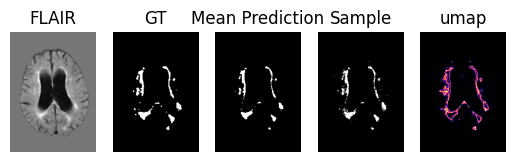

In [55]:
plot_example(70, 30)

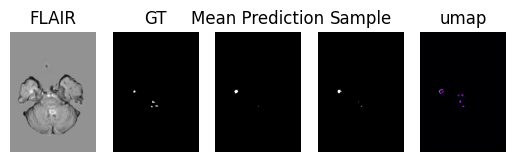

In [56]:
plot_example(11, 14)

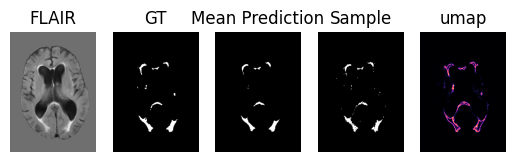

In [57]:
plot_example(70, 25)

### Plot FP and FN distributions vs volume

In [58]:
plt.style.use('fivethirtyeight')

In [ ]:
stride = 2

In [61]:
import pandas as pd

### Covereage of clusters in 2D slices

In [74]:
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis

In [77]:
uncertainty_thresholds = torch.arange(0, 0.7, 0.01)

conn_comp_2d_analysis(save_folder, results_file, uncertainty_thresholds, ys3d=ys3d_test, means3d=means, ind_ent_maps=ent_maps)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [10:07<00:00,  4.86s/it]


uncertainty thresholds
[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.089999996, 0.1, 0.11, 0.12, 0.13, 0.14, 0.14999999, 0.16, 0.17, 0.17999999, 0.19, 0.2, 0.21, 0.22, 0.22999999, 0.24, 0.25, 0.26, 0.26999998, 0.28, 0.29, 0.29999998, 0.31, 0.32, 0.32999998, 0.34, 0.35, 0.35999998, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42000002, 0.43, 0.44, 0.45000002, 0.46, 0.47, 0.48, 0.48999998, 0.5, 0.51, 0.52, 0.53, 0.53999996, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69]
mean coverage of areas missed by mean as tau increases
[0.87557805, 0.7760163, 0.7385587, 0.7111914, 0.68933725, 0.6711931, 0.6544996, 0.6381114, 0.6250597, 0.6123544, 0.60027915, 0.5892992, 0.5778249, 0.5680313, 0.5580449, 0.5474519, 0.5376239, 0.5290651, 0.52069855, 0.51291233, 0.50502115, 0.49714342, 0.4893073, 0.48112634, 0.47301388, 0.46607983, 0.4588245, 0.45166832, 0.4449706, 0.4372514, 0.4300472, 0.42428887, 0.41749766, 0.4103492, 0.40295115, 0.3960899, 0.38946745, 0.38249773,

### Energy Distance Score

In [78]:
# I will use the intersection over union as a metric?
means[0].shape

torch.Size([40, 2, 224, 160])

In [79]:
def iou(a, b):
    intersection = (a==1) & (b==1)
    union = (a==1) | (b==1)
    return intersection.sum()/union.sum()

In [80]:
import numpy as np
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write

In [81]:
def reorder_samples(sample):
    slice_volumes = sample.sum(dim=(-1, -2))
    slice_volume_orders = torch.sort(slice_volumes.T, dim=1)[1]
    
    # rearrange the samples into one...
    new_sample = torch.zeros(sample.shape).to(sample.device)
    for i, slice_volumes_orders in enumerate(slice_volume_orders):
        for j, sample_index in enumerate(slice_volumes_orders):
            new_sample[j][i] = sample[sample_index][i]
            
    return new_sample

In [82]:
def iou_GED(reorder=False):
    geds = []
    
    for i in tqdm(range(len(means)), position=0, leave=True):
        y = ys3d_test[i].cuda()
        ss = samples[i].cuda().argmax(dim=2)
        
        if reorder:
            ss = reorder_samples(ss)
        
        dists_ab = 0
        
        # print(y.sum())
        
        for s in ss:
            pred = s#.argmax(dim=1)
            dists_ab += iou(pred, y).item()
            # print(dists_ab)
            # print(s.shape)
        
        dists_ab /= ss.shape[0]
        dists_ab *= 2
        
        dists_ss = 0
        for s1 in ss:
            for s2 in ss:
                dists_ss += iou(s1, s2).item()
        
        dists_ss /= (ss.shape[0] ** 2)
        
        ged = dists_ab - dists_ss
        if not np.isnan(ged):
            geds.append(ged)
            
        #break
        
    return torch.Tensor(geds)

In [74]:
geds = iou_GED()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:07<00:00, 17.54it/s]


In [83]:
geds_reordered = iou_GED(reorder=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:11<00:00, 10.98it/s]


In [77]:
print_and_write(results_file, "reordered GED values", newline=1)
print_and_write(results_file, geds_reordered)

print_and_write(results_file, "reordered GED mean", newline=1)
print_and_write(results_file, geds_reordered.mean())

print_and_write(results_file, "reordered GED standard error", newline=1)
print_and_write(results_file, scipy.stats.sem(geds_reordered))

reordered GED values
[0.49976873, 0.43448585, 0.66666347, 0.17916746, 0.065695286, 0.357234, 0.13193688, 0.38290396, 0.43375555, 0.5249694, 0.5515738, 0.72890145, 0.23313262, 0.104362905, -0.06585588, 0.3438386, 0.5075395, -0.10179626, 0.33274776, 0.062893055, 0.31365156, -0.09185771, 0.17681703, 0.66106874, 0.16939928, -0.0061876173, 0.12537596, -0.15450591, -0.05914735, 0.4022111, 0.5403608, 0.32626605, 0.42188576, 0.38602728, 0.14282994, 0.11582688, 0.07465615, 0.4973212, 0.41329265, -0.22478421, 0.3739348, -0.23287137, 0.10528082, 0.45456776, -0.15249354, 0.20084123, -0.16633575, 0.25250745, 0.4543183, 0.4006774, 0.24848834, 0.6092348, 0.70257634, 0.29259098, 0.5563238, 0.6498168, 0.042424783, -0.08440804, 0.49322626, 0.051365077, 0.27264073, 0.41603625, 0.50833684, 0.67252606, 0.39036885, 0.6298391, 0.40387857, 0.011175249, 0.27572757, 0.3944007, 0.5471211, 0.23159985, -0.074349985, 0.59411514, 0.49102718, 0.08538818, 0.30551654, -0.29771808, 0.23163225, 0.2409719, 0.32970387, 0.1

### Sample diveristy when slice samples are sorted first by volume

In [85]:
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics

In [86]:
def per_model_chal_stats(preds3d, ys3d):
    stats = []
    for i in tqdm(range(len(ys3d)), position=0, leave=True):
        ind_stats = do_challenge_metrics(ys3d[i].type(torch.long), preds3d[i].argmax(dim=1).type(torch.long))
        stats.append(ind_stats)

    tstats = torch.Tensor(stats)
    dices = tstats[:,0]
    hd95s = tstats[:,1]
    avds = tstats[:,2]
    recalls = tstats[:,3]
    f1s = tstats[:,4]

    data = {"dice":dices, "hd95":hd95s, "avd":avds, "recall":recalls, "f1":f1s}

    return data

def write_model_metric_results(results_file, data):
    for key in data.keys():
        print_and_write(results_file, key, newline=1)
        print_and_write(results_file, data[key])
        
        # ignore any bad images, that will cause values of 0 to appear
        values = data[key]
        ignores = (values < 0.001) | torch.isnan(values)
        if key == 'avd':
            ignores = ignores | (values == 100)
        values = values[~ignores]
        
        print_and_write(results_file, f"{key} mean", newline=1)
        print_and_write(results_file, values.mean())
        
        print_and_write(results_file, f"{key} standard error", newline=1)
        print_and_write(results_file, scipy.stats.sem(values))

In [138]:
challenge_data = per_model_chal_stats(means, ys3d_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [02:14<00:00,  1.07s/it]


In [154]:
write_model_metric_results(results_file, challenge_data)

dice
[0.7981091, 0.77626073, 0.8823401, 0.6324862, 0.57787114, 0.72266185, 0.6047244, 0.7542579, 0.77035683, 0.8055626, 0.8265606, 0.90729946, 0.677686, 0.57810456, 0.46516854, 0.72446203, 0.8046768, 0.44560945, 0.71445495, 0.5781309, 0.71661305, 0.45852852, 0.6288525, 0.8827364, 0.6404658, 0.50297976, 0.6256983, 0.46898264, 0.51752424, 0.7659789, 0.8333227, 0.7295499, 0.7734799, 0.7473187, 0.64116377, 0.5956928, 0.57830584, 0.81271744, 0.779053, 0.41905963, 0.7623399, 0.40941793, 0.5835056, 0.78559035, 0.47071582, 0.67637026, 0.4603313, 0.6675239, 0.76660603, 0.7706391, 0.68911666, 0.84753287, 0.8954498, 0.6721268, 0.8371427, 0.87358415, 0.541103, 0.44270205, 0.80345964, 0.5727412, 0.6852952, 0.76475644, 0.8174909, 0.8802353, 0.75093424, 0.8638379, 0.75636774, 0.51668835, 0.6936922, 0.7433492, 0.82322043, 0.6741814, 0.51137257, 0.84453875, 0.7971062, 0.5686471, 0.70419425, 0.22286263, 0.6693157, 0.6829904, 0.708382, 0.6459144, 0.6481091, 0.25169554, 0.6578301, 0.67126375, 0.7531818, 0

In [90]:
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

def fast_avd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return ((p1 - t1).abs() / t1) * 100

def fast_vd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return ((p1 - t1) / t1) * 100

In [91]:
idx = 21

getAVD(ys3d_test[idx], means[idx].argmax(dim=1), ), fast_avd(means[idx].argmax(dim=1), ys3d_test[idx])

(28.209606986899566, tensor(28.2096))

In [92]:
def metric_across_samples_analysis(results_text_file, ys3d, samples3d, reorder=False, metric="dice", print_all_results=False):
    if metric=="dice":
        func = fast_dice
        order_func = torch.max
        device="cuda"
    elif metric=="avd":
        func = fast_avd
        device='cuda'
        order_func = torch.min
    elif metric=="vd":
        func = fast_vd
        device='cuda'
        order_func = torch.min
    
    results = []
    for ind in tqdm(range(len(samples3d)), position=0, leave=True, ncols=150):
        sample_results = []
        sample_set = samples3d[ind].to(device).argmax(dim=2)
        if reorder:
            sample_set = reorder_samples(sample_set.cuda()).to(device)
            
        y = ys3d[ind].to(device)
        
        try:
            for y_hat in sample_set:
                sample_results.append(func(y_hat, y))

            results.append(sample_results)
        except ZeroDivisionError:
            pass # ignore the values that arise from a dodgy flair

    results = torch.stack([torch.Tensor(ds) for ds in results], dim=0)
    
    best = order_func(results, dim=1)[0]
    
    reordername = "reordered " if reorder else ""
    
    if print_all_results:
        print_and_write(results_text_file, reordername + f"per sample {metric}", newline=1)
        print_and_write(results_text_file, results)
    print_and_write(results_text_file, reordername + f"best {metric} mean", newline=1)
    print_and_write(results_text_file, best.mean())
    print_and_write(results_text_file, reordername + f"best {metric} st_err", newline=1)
    print_and_write(results_text_file, scipy.stats.sem(best))
    
    return results

In [93]:
standard_sample_dices = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=False, metric="dice")
reorder_sample_dices = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=True, metric="dice")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 39.20it/s]


best dice mean
0.60340595
best dice st_err
0.015043093921315613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:07<00:00, 17.20it/s]


reordered best dice mean
0.6055772
reordered best dice st_err
0.014877286890673068


In [94]:
standard_sample_avds = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=False, metric="avd")
reorder_sample_avds = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=True, metric="avd")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 43.30it/s]


best avd mean
41.059265
best avd st_err
8.30702051455719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.18it/s]


reordered best avd mean
34.36136
reordered best avd st_err
7.172178484317488


In [95]:
def vd_per_sample(ys3d, samples3d, reorder=False):
    device='cuda'
    results = []
    for ind in tqdm(range(len(samples3d)), position=0, leave=True, ncols=150):
        sample_results = []
        sample_set = samples3d[ind].to(device).argmax(dim=2)
        if reorder:
            sample_set = reorder_samples(sample_set.cuda()).to(device)
            
        y = ys3d[ind].to(device)
        
        for y_hat in sample_set:
            sample_results.append(fast_vd(y_hat, y))

        results.append(sample_results)

    results = torch.stack([torch.Tensor(ds) for ds in results], dim=0)
    
    return results

In [96]:
def GT_volumes(ys3d):
    volumes = []
    for y in ys3d:
        volumes.append(y.sum())
    return torch.Tensor(volumes)

In [97]:
standard_sample_VDS = vd_per_sample(ys3d_test, samples, reorder=False)
reorder_sample_VDS = vd_per_sample(ys3d_test, samples, reorder=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.40it/s]


In [98]:
gt_vols = GT_volumes(ys3d_test)

In [99]:
def sample_diversity_plot(save_folder, sample_metrics_3d, metric_name):
    # sort in order of quality
    order = torch.sort(torch.median(sample_metrics_3d, dim=1)[0])[1]
    plt.figure(figsize=(20, 5))
    plt.boxplot(sample_metrics_3d[order]);
    plt.ylim(-0.5, 2.5);
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.ylabel(f"{metric_name}")
    #plt.yscale('log')
    plt.xlabel("Individuals")
    save(save_folder, "sample_diversity_plot")

In [100]:
def sample_diversity_plot_by_volume(save_folder, sample_metrics_3d, volumes, metric_name):
    # sort in order of quality
    order = torch.sort(volumes)[1]
    fig, ax = plt.subplots(figsize=(20, 5))
    #plt.figure(figsize=(20, 5))
    ax.boxplot(sample_metrics_3d[order]);
    # ax.set_xticklabels(np.array(volumes[order] * 0.003))
    # plt.xticks(rotation = 90)
    plt.ylim(-0.5, 2.5);
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    plt.ylabel(f"{metric_name}")
    #plt.yscale('log')
    plt.xlabel("Individuals, sorted by WMH Volume")
    
    save(save_folder, "sample_diversity_plot")

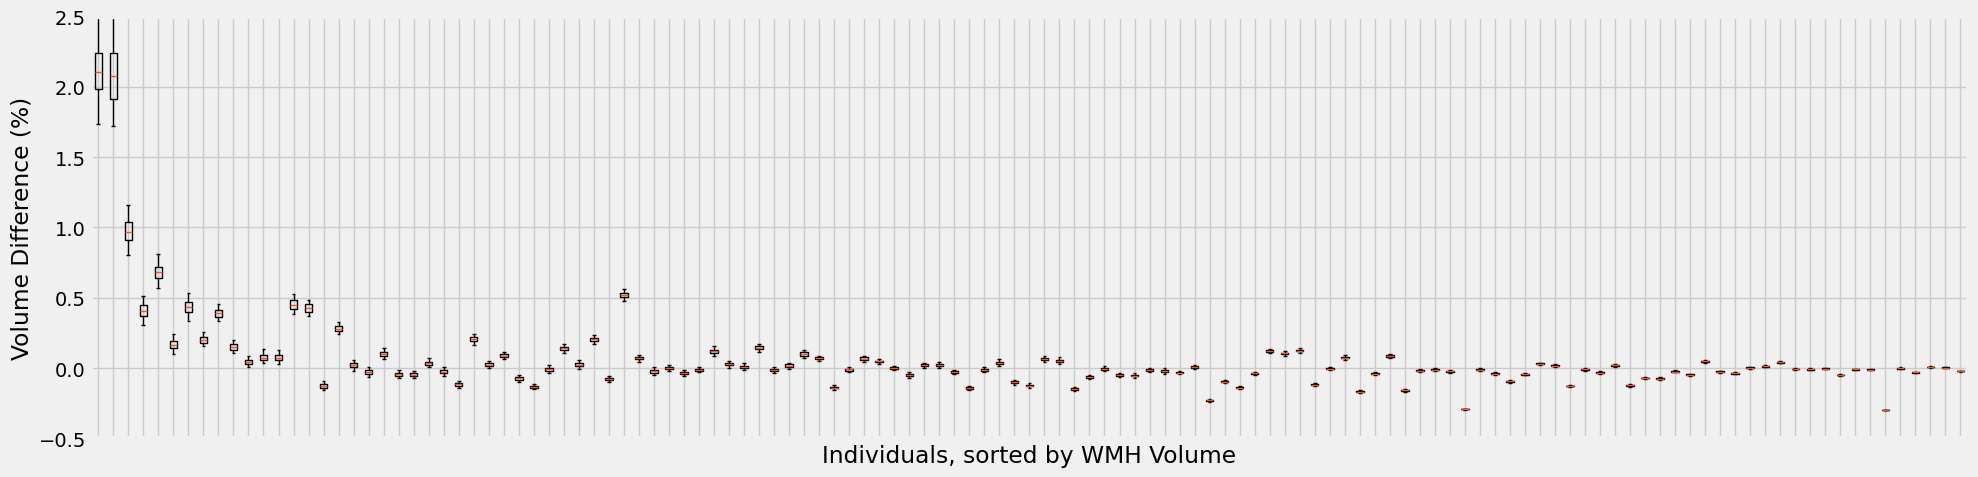

In [101]:
sample_diversity_plot_by_volume(save_folder, reorder_sample_VDS*0.003, gt_vols, "Volume Difference (%)")

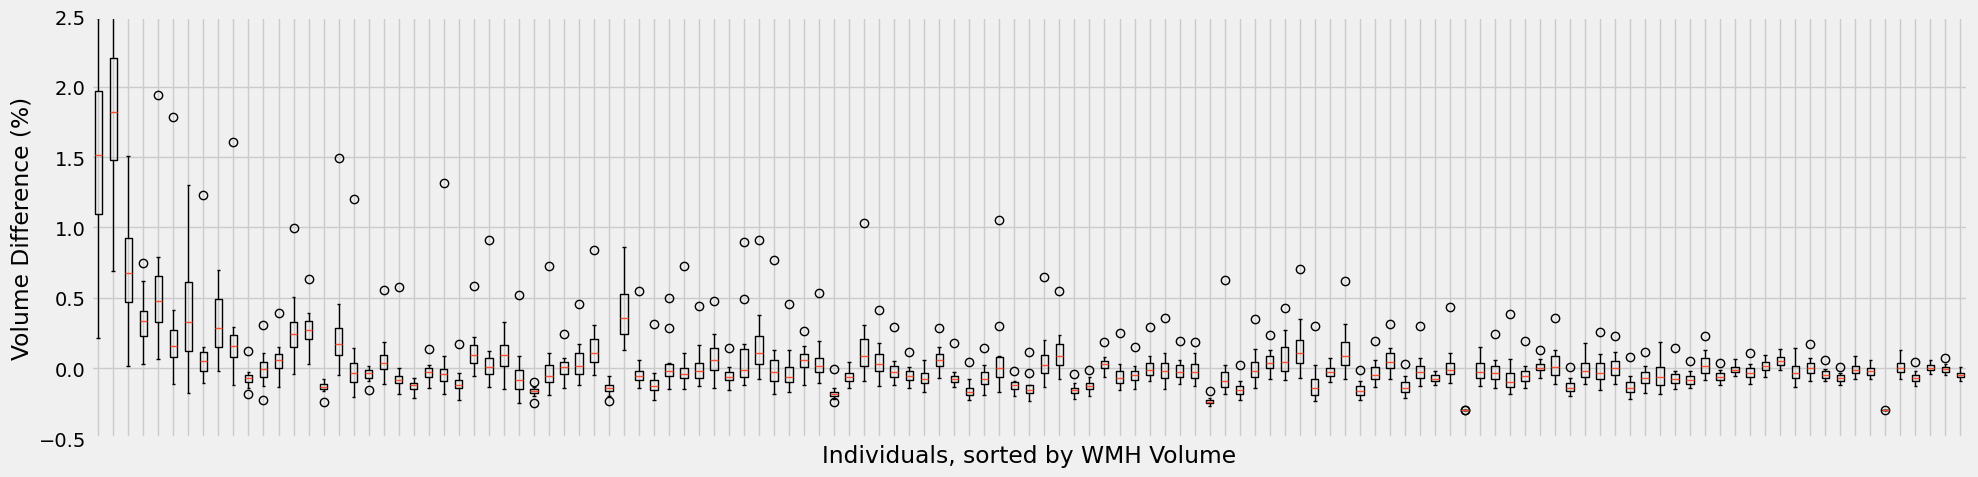

In [372]:
sample_diversity_plot_by_volume(save_folder, reorder_sample_VDS*0.003, gt_vols, "Volume Difference (%)")

### Bras Score and sUEO score

In [102]:
# for bras, we need three metrics, AUC Dice, flitered true positives, and filtered true negatives.

In [103]:
def filtered_dice(pred, ent_map, target, threshold):
    uncertain_locs = ent_map < threshold
    remaining_pred = pred[uncertain_locs]
    remaining_target = target[uncertain_locs]
    
    return fast_dice(remaining_pred, remaining_target)

In [104]:
filtered_dice(means[0].argmax(dim=1), ent_maps[0], ys3d_test[0], 0.0)

0.0

In [105]:
fast_dice(means[0].argmax(dim=1), ys3d_test[0])

0.7986268401145935

In [106]:
def filtered_tps_score(pred, ent_map, target, threshold):
    total_tps = ((pred == 1) & (target == 1)).sum().item()
    uncertain_locs = ent_map < threshold
    
    filtered_tps = ((pred[uncertain_locs] == 1) & (target[uncertain_locs] == 1)).sum().item()
    
    return (total_tps - filtered_tps) / total_tps

In [107]:
def filtered_tns_score(mask, pred, ent_map, target, threshold):
    mask = mask.type(torch.bool)
    pred = pred[mask]
    ent_map = ent_map[mask]
    target = target[mask]
    
    total_tns = ((pred == 0) & (target == 0)).sum().item()
    uncertain_locs = ent_map < threshold
    
    filtered_tns = ((pred[uncertain_locs] == 0) & (target[uncertain_locs] == 0)).sum().item()
    
    return (total_tns - filtered_tns) / total_tns

In [108]:
from sklearn import metrics
import math

In [109]:
uncertainty_thresholds = torch.arange(0, 0.7, 0.01)

filtered_dices = []
filtered_tns = []
filtered_tps = []

for i in tqdm(range(len(means)), position=0, leave=True):
    mean = means[i].cuda().argmax(dim=1)
    ent_map = ent_maps[i].cuda()
    y = ys3d_test[i].cuda()
    mask = xs3d_test[i][1].cuda()
    
    ind_filtered_dices = []
    ind_filtered_tns = []
    ind_filtered_tps = []
    
    if mean.sum() == 0:
        continue
            
    for t in uncertainty_thresholds:
        ind_filtered_dices.append(filtered_dice(mean, ent_map, y, t))
        ind_filtered_tns.append(filtered_tns_score(mask, mean, ent_map, y, t))
        ind_filtered_tps.append(filtered_tps_score(mean, ent_map, y, t))
        
    filtered_dices.append(ind_filtered_dices)
    filtered_tns.append(ind_filtered_tns)
    filtered_tps.append(ind_filtered_tps)
    

# we need to calculate the area under the curve of the dice, so that will be mean dice per threshold?


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:23<00:00,  5.33it/s]


In [110]:
filtered_dices = torch.stack([torch.Tensor(v) for v in filtered_dices], dim=0)
filtered_tns = torch.stack([torch.Tensor(v) for v in filtered_tns], dim=0)
filtered_tps = torch.stack([torch.Tensor(v) for v in filtered_tps], dim=0)

In [111]:
fdice_curve = filtered_dices.mean(dim=0)
tn_curve = filtered_tns.mean(dim=0)
tp_curve = filtered_tps.mean(dim=0)

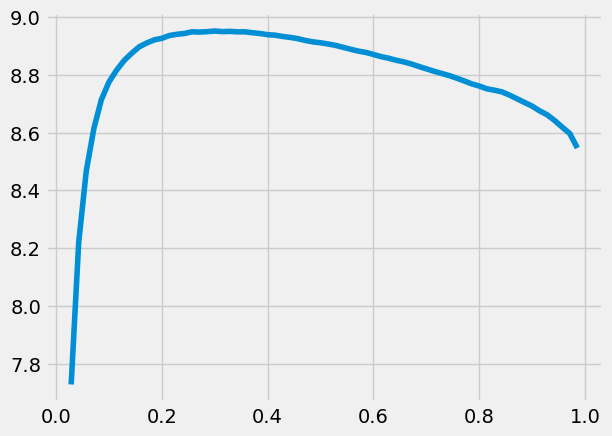

In [112]:
plt.plot(uncertainty_thresholds[2:]/0.7, fdice_curve[2:]/0.1 + (1-tn_curve[2:]) + (1-tp_curve[2:]))

In [113]:
max_ent = math.log(0.5)

In [114]:
bras_score = (1/3) * (
    metrics.auc(uncertainty_thresholds/max_ent, fdice_curve)
     + (1 - metrics.auc(uncertainty_thresholds/max_ent, tn_curve))
     + (1 - metrics.auc(uncertainty_thresholds/max_ent, tp_curve))
)

In [115]:
print_and_write(results_file, "bras score", newline=1)
print_and_write(results_file, bras_score)

bras score
0.7694719918072224


In [116]:
# now compute the UEO, sUEO and sUEO score....
def sUEO(pred, ent_map, target):
    errors = (pred != target)
    
    numerator = 2 * (ent_map * errors).sum()
    denominator = (errors**2).sum() + (ent_map**2).sum()
    
    return (numerator / denominator).item()


In [117]:
sUEOs = []
for i in tqdm(range(len(means)), position=0, leave=True):
    pred = means[i].argmax(dim=1).cuda()
    target = ys3d_test[i].cuda()
    ent = ent_maps[i].cuda()
    
    if pred.sum() == 0:
        continue
    
    sUEOs.append(sUEO(pred, ent, target))

sUEOs = torch.Tensor(sUEOs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:25<00:00,  4.95it/s]


In [118]:
print_and_write(results_file, "sUEO mean", newline=1)
print_and_write(results_file, sUEOs.mean())

print_and_write(results_file, "sUEO standard error", newline=1)
print_and_write(results_file, scipy.stats.sem(sUEOs))

sUEO mean
0.46416834
sUEO standard error
0.005977360447868564


In [202]:
print_and_write(results_file, "sUEO mean", newline=1)
print_and_write(results_file, sUEOs.mean())

print_and_write(results_file, "sUEO standard error", newline=1)
print_and_write(results_file, scipy.stats.sem(sUEOs))

sUEO mean
0.44134057
sUEO standard error
0.004713116433533787


In [119]:
def UEO_per_threshold_analysis(save_folder, text_results_file, uncertainty_thresholds, ys3d, ind_ent_maps, means, max_ent):
    ueos = [[] for _ in range(len(uncertainty_thresholds))]
                              
    for i in tqdm(range(len(ys3d)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d[i].cuda()
        ent = ind_ent_maps[i].cuda()
        
        if pred.sum() == 0:
            continue
        
        for j, t in enumerate((uncertainty_thresholds)):
            ueos[j].append(sUEO(pred, (ent > t).type(torch.float32), target))
    
    ueos = torch.stack([torch.Tensor(ind_ueo) for ind_ueo in ueos], dim=0)
    ueos = ueos.mean(dim=1)

    best_index = torch.Tensor(ueos).argmax()
    print_and_write(text_results_file, f"best tau for max UEO", newline=1)
    print_and_write(text_results_file, uncertainty_thresholds[best_index])
    print_and_write(text_results_file, "max UEO", newline=1)
    print_and_write(text_results_file, ueos[best_index])

    print_and_write(text_results_file, f"UEO per tau", newline=1)
    print_and_write(text_results_file, torch.Tensor(ueos))


    plt.plot(uncertainty_thresholds, ueos)
    plt.xlabel("τ")
    plt.ylabel("UEO")
    save(save_folder, "UEO")

    print_and_write(text_results_file, f"UEO tau AUC", newline=1)
    print_and_write(text_results_file, metrics.auc(uncertainty_thresholds/max_ent, ueos))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:28<00:00,  4.36it/s]


best tau for max UEO
0.38
max UEO
0.40855005
UEO per tau
[0.0036448436, 0.15353787, 0.19465981, 0.22300635, 0.24479324, 0.2626269, 0.27770534, 0.2905902, 0.3019162, 0.31205, 0.32096168, 0.32922873, 0.33662555, 0.3435545, 0.34973496, 0.3555454, 0.36064568, 0.36547944, 0.3698827, 0.37394443, 0.3777661, 0.38138303, 0.38462073, 0.38771337, 0.3905199, 0.3930835, 0.39530104, 0.3971392, 0.39890924, 0.40067178, 0.40212294, 0.40353808, 0.404804, 0.40575767, 0.40651906, 0.4074283, 0.40808368, 0.40850177, 0.40855005, 0.4084587, 0.40812215, 0.40784293, 0.40724552, 0.40627903, 0.40546018, 0.4044357, 0.40287286, 0.40143803, 0.3994455, 0.39732113, 0.394935, 0.39203608, 0.3890062, 0.3853005, 0.38121554, 0.37653264, 0.3720025, 0.36661854, 0.36110312, 0.3542002, 0.34651563, 0.33737782, 0.32751384, 0.31615922, 0.30195636, 0.28494948, 0.26304775, 0.23481432, 0.19288895, 0.10836974]


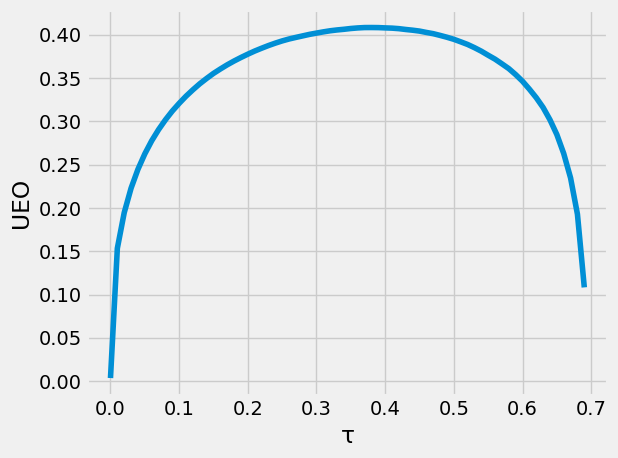

UEO tau AUC
0.3493054211139679


In [120]:
UEO_per_threshold_analysis(save_folder, results_file, uncertainty_thresholds, ys3d_test, ent_maps, means, max_ent)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:28<00:00,  4.44it/s]


best tau for max UEO
0.43
max UEO
0.40558767
UEO per tau
[0.0033681944, 0.10128273, 0.13063945, 0.1516851, 0.16858695, 0.18287787, 0.1955715, 0.20685147, 0.21732177, 0.22690482, 0.235868, 0.24422216, 0.25227472, 0.25996968, 0.26735282, 0.27421626, 0.2810417, 0.287673, 0.29407302, 0.30025506, 0.30641404, 0.3123443, 0.31828314, 0.323861, 0.32953826, 0.33523852, 0.34080923, 0.34641525, 0.35231784, 0.35786587, 0.36401978, 0.3703144, 0.37750208, 0.38443252, 0.38876042, 0.39193743, 0.39492655, 0.3976336, 0.39988318, 0.40141186, 0.4030455, 0.40406048, 0.40499288, 0.40558767, 0.4054556, 0.40528035, 0.40490103, 0.40406772, 0.402903, 0.40153733, 0.39975637, 0.3973705, 0.39480844, 0.3914821, 0.38780582, 0.383513, 0.3787279, 0.37330857, 0.36649057, 0.3592698, 0.3513434, 0.34207922, 0.3315798, 0.318901, 0.30455822, 0.28734347, 0.26508185, 0.23585008, 0.19345342, 0.10860208]


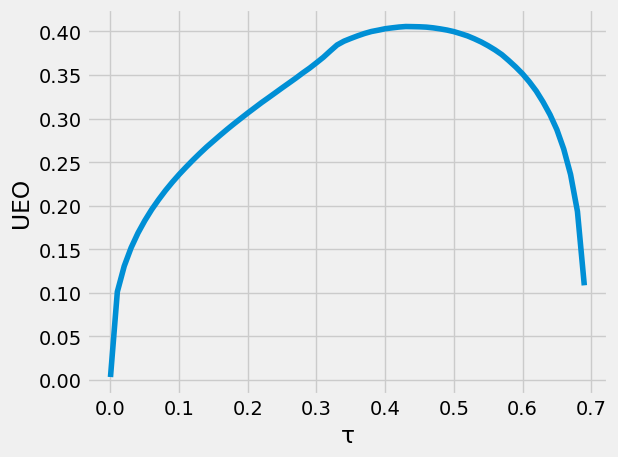

UEO tau AUC
0.31787070631980896


In [210]:
UEO_per_threshold_analysis(save_folder, results_file, uncertainty_thresholds, ys3d_test, ent_maps, means, max_ent)

### Looking again at model calibration

In [121]:
torch.randn(12, 12).median(dim=0)[0]

tensor([-0.4308, -0.2418, -0.3346, -0.2963, -0.2026,  0.0233, -0.2321,  0.8467,
         0.0338, -0.4343,  0.2868,  0.0476])

In [84]:
# we can compute the calibration using the mean confidence from our uncertainty maps - and just leave it at that. Nice.
# do mean conf, min conf, and max conf. Nice.
import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples


def calibration_over_samples(save_folder, results_file, means3d, samples3d, ys3d, do_normalize, mode="mean_conf"):
    bins = 10 + 1 # for the 0 bin
    bin_batch_accuracies = [[] for b in range(bins)]
    bin_batch_confidences = [[] for b in range(bins)]
    bin_batch_sizes = [[] for b in range(bins)]
    bin_counts = [0 for b in range(bins)]
    for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        batch_t = ys3d[batch_idx].squeeze().cuda()
        batch_samples = samples3d[batch_idx].cuda()

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        if do_normalize:
            probs = normalize_samples(batch_samples)
        else:
            probs = batch_samples
        p1s = probs[:,:,1]
        
        if mode == "all_samples":
            p1s = p1s # ie do nothing, use each sample
        elif mode == "mean_conf":
            p1s = p1s.mean(dim=0)
        elif mode == "min_conf":
            p1s = p1s.min(dim=0)[0]
        elif mode == "median_conf":
            p1s = p1s.median(dim=0)[0]
        elif mode == "max_conf":
            p1s = p1s.max(dim=0)[0]
        elif mode == "mean_only":
            if do_normalize:
                p1s = torch.softmax(means3d[batch_idx].cuda(), dim=1)[:,1]
            else:
                p1s = means3d[batch_idx][:,1]
        else:
            raise ValueError(f"mode: {mode} not accepted") 
            

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            # if num_elem == 0:
            #     print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem

            # if torch.isnan(c1_acc):
            #     print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            # if torch.isnan(c1_conf):
            #     print("conf_nan")
                
            if torch.isnan(c1_conf) or torch.isnan(c1_acc) or num_elem == 0:
                #print("conf_nan") # just skip for this bin for this indivudal if they don't have have a prediction
                # with a confidence in this bin.
                continue

            bin_batch_accuracies[i].append(c1_acc.item())
            bin_batch_confidences[i].append(c1_conf.item())
            bin_batch_sizes[i].append(num_elem)

    bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
    bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
    bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]

    print_and_write(results_file, f"{mode} calibration curve data: ")

    print_and_write(results_file, f"{mode} bin_accuracies: ", newline=1)
    print_and_write(results_file, str(bin_accuracies))

    print_and_write(results_file, f"{mode} bin_confidences: ", newline=1)
    print_and_write(results_file, str(bin_confidences))

    total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
    ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
    print_and_write(results_file, f"{mode} EXPECTED CALIBRATION ERROR", newline=1)
    print("note we skip the first bin due to its size")
    print_and_write(results_file, ece)

    plt.plot(bin_confidences, bin_accuracies)
    plt.plot([0,1],[0,1]);
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy");
    save(save_folder, f"{mode} calibration")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:04<00:00,  8.86it/s]


mean_only calibration curve data: 
mean_only bin_accuracies: 
[0.00019185473502147943, 0.06159614771604538, 0.14056095480918884, 0.21839959919452667, 0.2934909462928772, 0.37111952900886536, 0.46086570620536804, 0.5568118691444397, 0.6763080358505249, 0.8204531669616699, 0.9726805090904236]
mean_only bin_confidences: 
[0.00030868337489664555, 0.08799074590206146, 0.1946544498205185, 0.29694944620132446, 0.3978913724422455, 0.4988612234592438, 0.5996091365814209, 0.7000769376754761, 0.8016769289970398, 0.9051195383071899, 0.9877729415893555]
mean_only EXPECTED CALIBRATION ERROR
note we skip the first bin due to its size
0.05812372


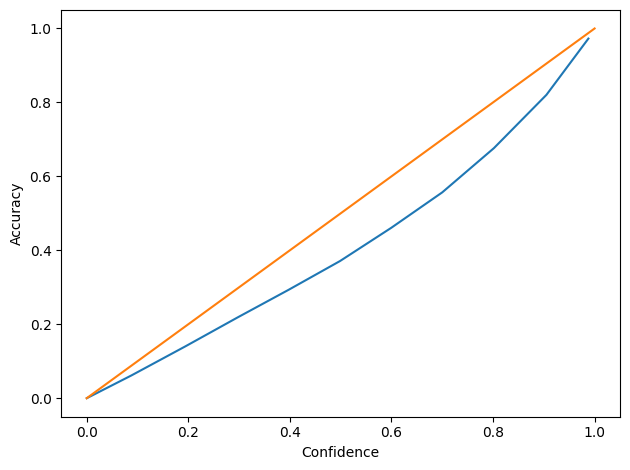

In [85]:
# for softmax entropy
calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=True, mode="mean_only")

# For evidential
calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=False, mode="mean_only")

# for other models
calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=True, mode="mean_conf")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:03<00:00, 38.81it/s]


mean_conf calibration curve data: 
mean_conf bin_accuracies: 
[0.000411149172578007, 0.07652120292186737, 0.2044624239206314, 0.30105072259902954, 0.3914419710636139, 0.47304973006248474, 0.5477064847946167, 0.624557375907898, 0.7112922668457031, 0.8410079479217529, 0.960421085357666]
mean_conf bin_confidences: 
[0.0002391172747593373, 0.08627365529537201, 0.19389232993125916, 0.29628658294677734, 0.39824968576431274, 0.4995621144771576, 0.6002310514450073, 0.7016150951385498, 0.8031210899353027, 0.9066312313079834, 0.9843829274177551]
mean_conf EXPECTED CALIBRATION ERROR
note we skip the first bin due to its size
0.025154896


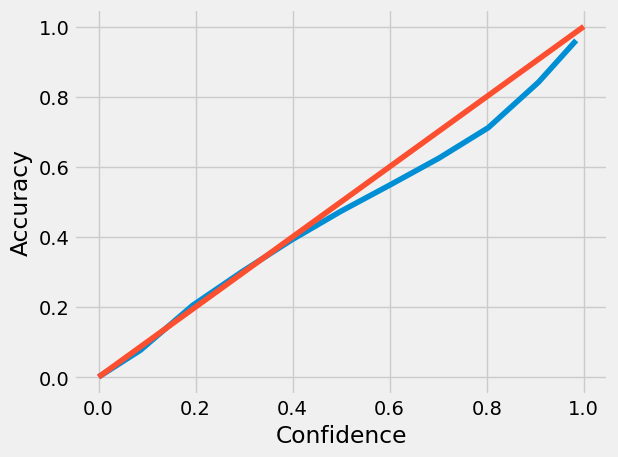